In [ ]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# create a new column for binarized (boolean) quality
data['boolQuality'] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
data['boolQuality'][data['quality']>5] = 1

<ipython-input-4-6f5cb70bcde3>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['boolQuality'][data['quality']>5] = 1


In [ ]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['boolQuality'].values ).float()
labels = labels[:,None] # transform to matrix

In [ ]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [ ]:
# create a class for the model
class ANNwine(nn.Module):
  def __init__(self,actfun):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)

    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)

    # activation funcion to pass through
    self.actfun = actfun

  # forward pass
  def forward(self,x):
    # get activation function type
    # this code replaces torch.relu with torch.<self.actfun>
    actfun = getattr(torch.nn,self.actfun)
    actFunc = actfun()

    x = self.input(x)
    x = actFunc(x)

    x = self.fc1(x)
    x = actFunc(x)

    x = self.fc2(x)
    x = actFunc(x)

    return self.output(x)

In [ ]:
# test the model
# use sigmoid, relu, tanh

net = ANNwine('ReLU')
sample = torch.randn(10,11)
net(sample)

tensor([[0.0637],
        [0.0616],
        [0.0653],
        [0.0551],
        [0.0866],
        [0.1758],
        [0.0791],
        [0.0628],
        [0.0796],
        [0.0548]], grad_fn=<AddmmBackward0>)

In [ ]:
# a function that trains the model

# global parameter
numepochs = 1000

def trainTheModel():

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(winenet.parameters(),lr=.01)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # turn on training mode
    winenet.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    winenet.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )

  # function output
  return trainAcc,testAcc,losses

In [ ]:
# this cell takes ~2 mins

# list activation functions to test
activation_funs = [ 'ReLU', 'LeakyReLU', 'ReLU6' ]

trainByAct = np.zeros((numepochs,len(activation_funs)))
testByAct  = np.zeros((numepochs,len(activation_funs)))

for ai,actfun in enumerate(activation_funs):
  # create a model and train it
  winenet = ANNwine(actfun)
  trainByAct[:,ai],testByAct[:,ai],losses = trainTheModel()


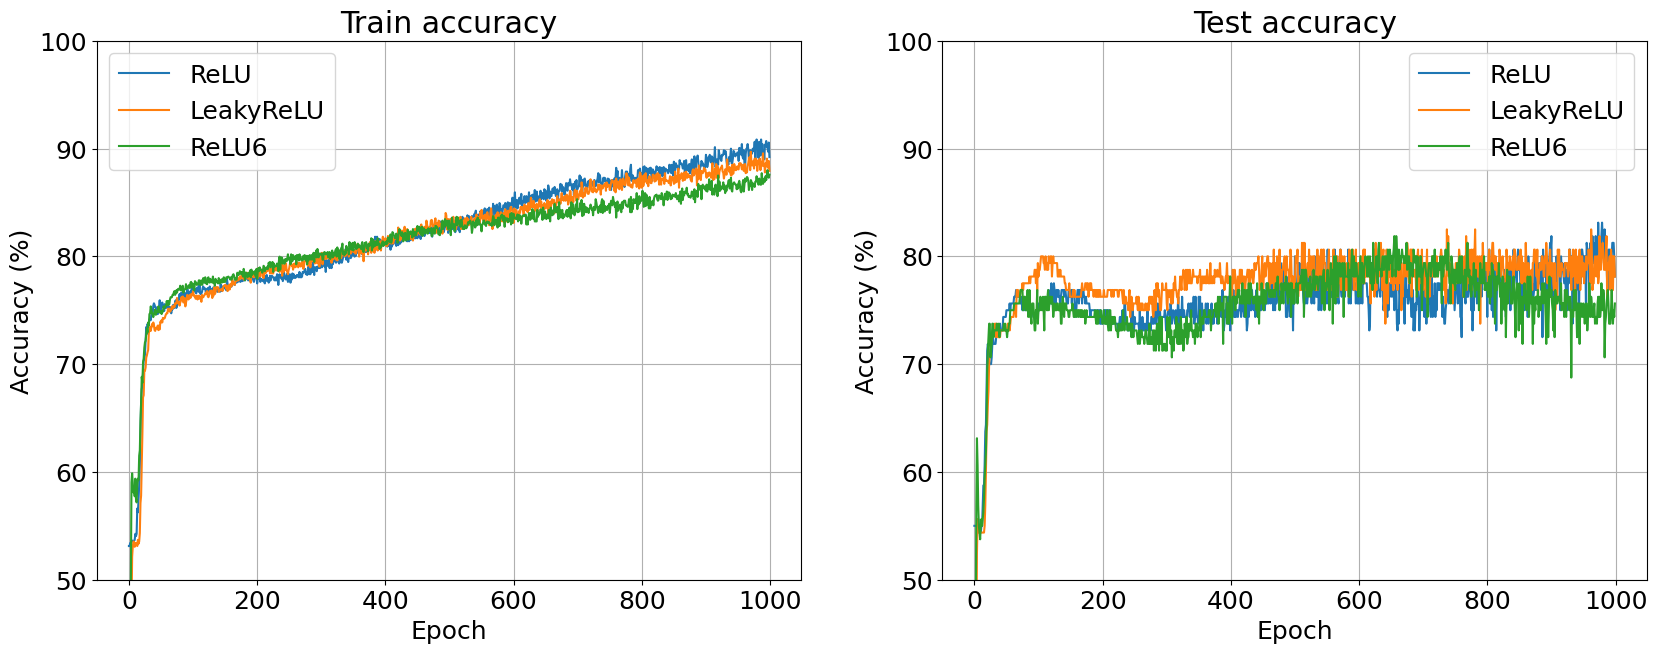

In [ ]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(20,7))

ax[0].plot(trainByAct)
ax[0].set_title('Train accuracy')
ax[1].plot(testByAct)
ax[1].set_title('Test accuracy')

# common features
for i in range(2):
  ax[i].legend(activation_funs)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,100])
  ax[i].grid()

plt.show()